# Appendix Plot - Filter Scale

Investigating visual differences with various filter scales

In [1]:
import json
import gcsfs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cm26_utils import load_and_combine_cm26

# set up gcs filesystem
# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

ds_merged  = load_and_combine_cm26(fs)
ds_merged

<xarray.Dataset>
Dimensions:       (xt_ocean: 3600, yt_ocean: 2700, time: 7305)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    v_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    u_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    t_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    q_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    wind          (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    surface_temp  (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    u_ocean       (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    v_ocean       (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    u_relative    (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    v_relative    (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [2]:
# pick example timesteps and only some variables
sample_time = [0,120, 240]

# smooth_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp']
smooth_vars = ['surface_temp']

ds = ds_merged[smooth_vars].isel(time=sample_time)
ds

<xarray.Dataset>
Dimensions:       (xt_ocean: 3600, yt_ocean: 2700, time: 3)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0181-08-29 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    surface_temp  (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [3]:
from filtering import smooth_inputs

for var in smooth_vars:
    filtered_dataarrays = []
    for filter_scale in [10, 20, 40, 50, 60, 80, 100, 200]:
        var_wet_mask = (~np.isnan(ds[var].isel(time=0))).astype(int) # build wet mask for each variable separately from first timestep
        da_smoothed = smooth_inputs(ds[var], var_wet_mask, ['xt_ocean', 'yt_ocean'], filter_scale)
        da_smoothed = da_smoothed.assign_coords(filter_scale=filter_scale)
        filtered_dataarrays.append(da_smoothed)
    ds[var+'_smoothed'] = xr.concat(filtered_dataarrays, 'filter_scale')

In [4]:
from dask.diagnostics import ProgressBar

# Load example time steps into memory
with ProgressBar():
    ds = ds.load()

[########################################] | 100% Completed | 290.36 s


1
2
3
4
5
6
7
8


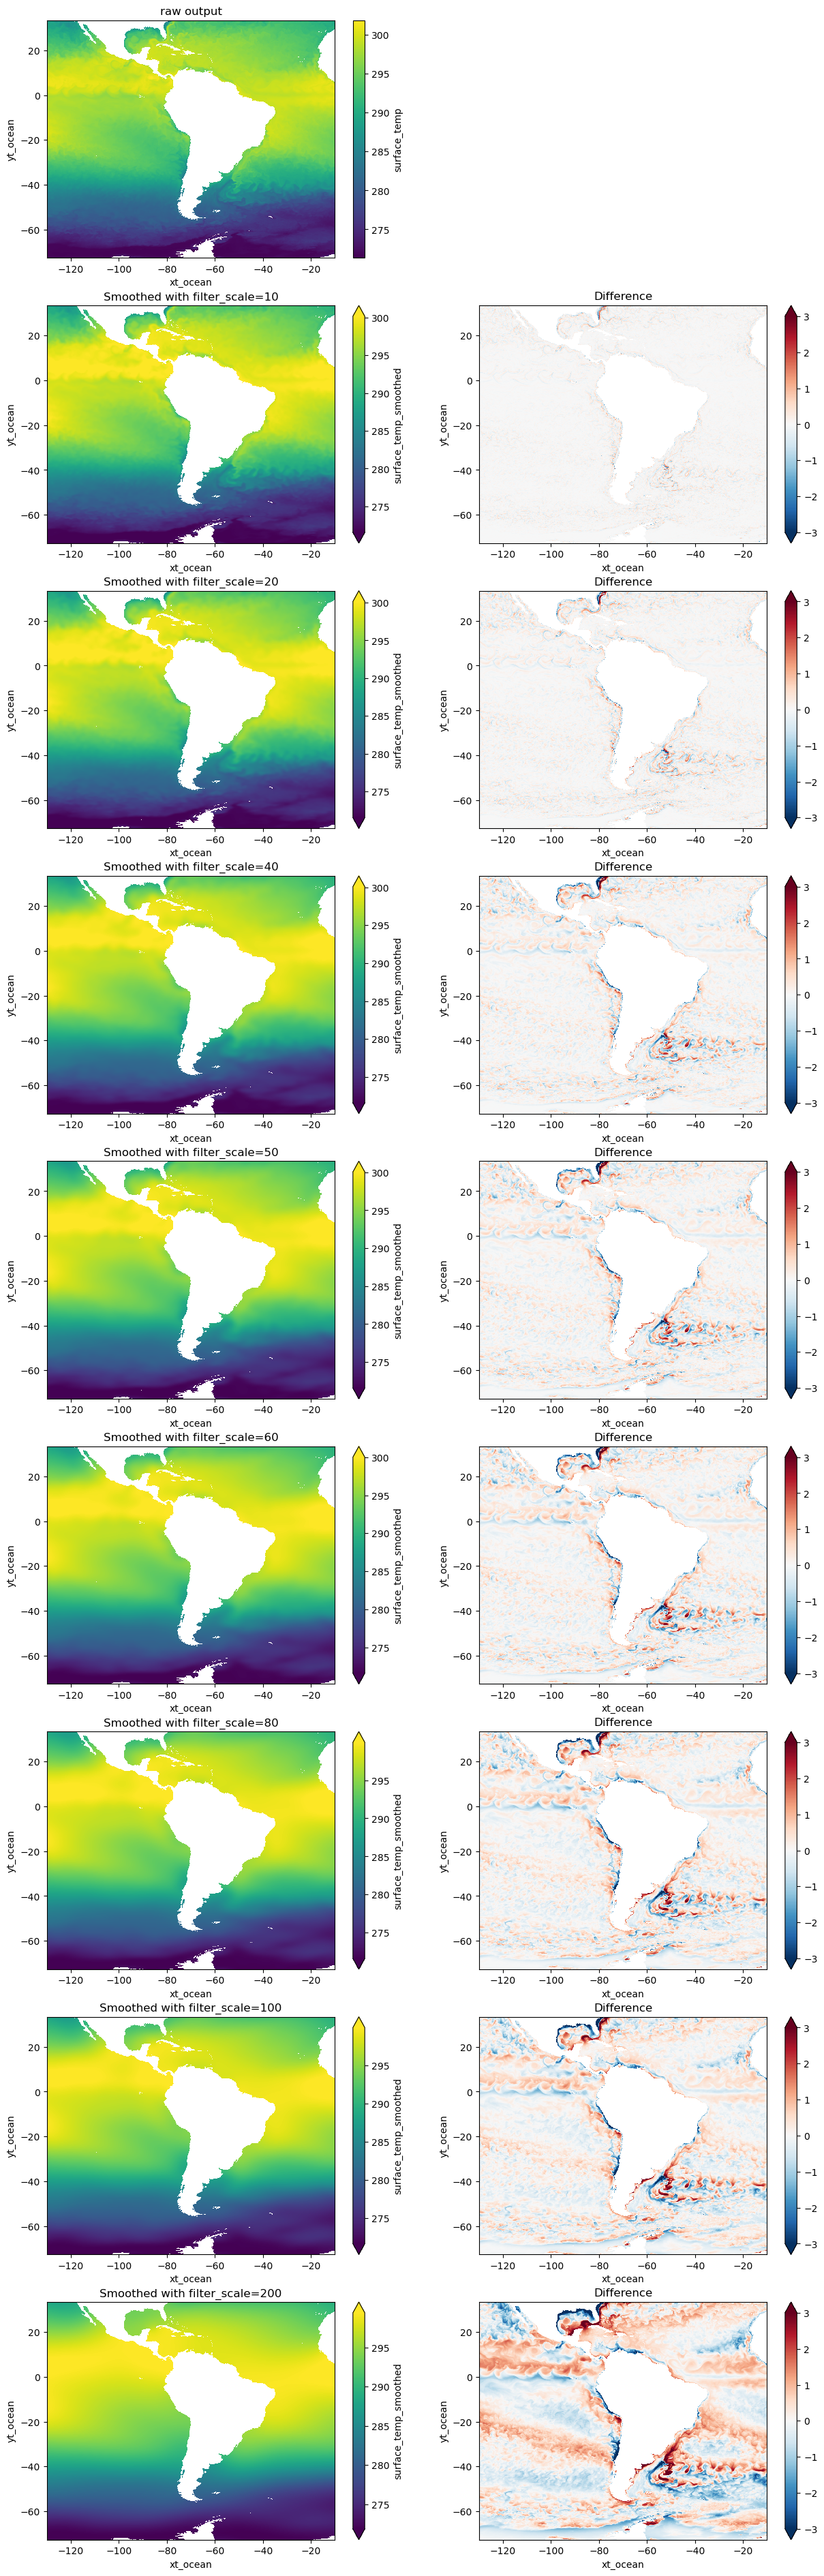

In [5]:
var = 'surface_temp'
plot_kwargs = {'x':'xt_ocean'}

for tt in range(len(ds.time)):
    
    # subset a region to see fine details
    ds_sample = ds.isel(xt_ocean=slice(1500, 2700), yt_ocean=slice(200, 1600), time=tt)

    fig, axarr = plt.subplots(nrows=len(ds.filter_scale)+1, ncols=2, figsize=[15, 6*len(ds.filter_scale)])
    
    # plot unfiltered field
    ax = axarr[0,0]
    da_raw = ds_sample[var]
    da_raw.plot(ax=ax, **plot_kwargs)
    ax.set_title('raw output')
    axarr[0,1].set_visible(False)
    
    for fi, fs in enumerate(ds_sample.filter_scale):
        da = ds_sample[var+'_smoothed'].sel(filter_scale=fs)
        print(fi+1)
        ax_smoothed = axarr[fi+1, 0]
        ax_diff = axarr[fi+1, 1]

        
        # smoothed output
        da.plot(ax=ax_smoothed,robust=True, **plot_kwargs)
        (da_raw-da).plot(ax=ax_diff, vmax=3,  **plot_kwargs)
        
        ax_smoothed.set_title(f'Smoothed with filter_scale={fs}')
        ax_diff.set_title('Difference')
        
    plt.show()
    break

In [6]:

# Check that these dont show any artifacts or large scale features
plot_kwargs = {'x':'xt_ocean', 'robust':True}
for var in ['surface_temp']:
    print(var)
    fig, axarr = plt.subplots(nrows=len(ds_sample.time), ncols=3, figsize=[25,10])
    for tt in range(len(ds_sample.time)):
        print(tt)
        axarr_sub = axarr[tt, :].flat
        raw = ds_sample[var].isel(time=tt)
        smoothed = ds_sample[var+'_smoothed'].isel(time=tt)
        diff = raw - smoothed
        
        # unsmoothed result
        raw.plot(ax=axarr_sub[0], **plot_kwargs)
        
        # smoothed result
        smoothed.plot(ax=axarr_sub[1], **plot_kwargs)
        
        # difference
        diff.plot(ax=axarr_sub[2], **plot_kwargs)
    plt.show()

surface_temp


TypeError: len() of unsized object